In [293]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split

In [294]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [295]:
df = pd.read_csv('fight_with_stats_precomp.csv')
df_fighters = pd.read_csv('fighter_total_stats.csv')

In [296]:
df_fighters_details = pd.read_csv('fighter_details.csv', parse_dates=True)

In [297]:
df = df[(df['fightNo_fighter']>=3) & (df['fightNo_opponent']>=3) & (df['Women_fight']==0)]

In [298]:
df = df.fillna(0)


In [299]:
df.head()

,EVENT,BOUT,FIGHTER,OPPONENT,METHOD,Win,Women_fight,ROUND,HEIGHT_diff,REACH_diff,...,BODY_landed_opponent,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent
24,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground,0,0,1,1.0,0.0,...,0.0,0.0,3.0,5.0,5.0,10.0,0.0,0.0,0.0,0.0
25,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground,1,0,1,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,5.0
26,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission,0,0,1,2.0,0.0,...,0.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0
27,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission,1,0,1,-2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0,5.0
50,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission,0,0,1,1.0,0.0,...,3.0,4.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0


In [300]:
df.shape

(6817, 63)

In [301]:
df.columns.tolist()[19:]

['KD_fighter',
 'SUB.ATT_fighter',
 'REV._fighter',
 'CTRL_fighter',
 'SIG.STR._landed_fighter',
 'SIG.STR._attemps_fighter',
 'TOTAL STR._landed_fighter',
 'TOTAL STR._attemps_fighter',
 'TD_landed_fighter',
 'TD_attemps_fighter',
 'HEAD_landed_fighter',
 'HEAD_attemps_fighter',
 'BODY_landed_fighter',
 'BODY_attemps_fighter',
 'LEG_landed_fighter',
 'LEG_attemps_fighter',
 'DISTANCE_landed_fighter',
 'DISTANCE_attemps_fighter',
 'CLINCH_landed_fighter',
 'CLINCH_attemps_fighter',
 'GROUND_landed_fighter',
 'GROUND_attemps_fighter',
 'KD_opponent',
 'SUB.ATT_opponent',
 'REV._opponent',
 'CTRL_opponent',
 'SIG.STR._landed_opponent',
 'SIG.STR._attemps_opponent',
 'TOTAL STR._landed_opponent',
 'TOTAL STR._attemps_opponent',
 'TD_landed_opponent',
 'TD_attemps_opponent',
 'HEAD_landed_opponent',
 'HEAD_attemps_opponent',
 'BODY_landed_opponent',
 'BODY_attemps_opponent',
 'LEG_landed_opponent',
 'LEG_attemps_opponent',
 'DISTANCE_landed_opponent',
 'DISTANCE_attemps_opponent',
 'CLINCH

In [302]:
df = df.merge(df[['EVENT', 'BOUT', 'FIGHTER']+df.columns.tolist()[15:]] ,how='left', left_on=['EVENT', 'BOUT', 'OPPONENT'], right_on=['EVENT', 'BOUT', 'FIGHTER'], suffixes=('_f1', '_f2'))

In [303]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 112 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    EVENT                           6817 non-null   object 
 1    BOUT                            6817 non-null   object 
 2    FIGHTER_f1                      6817 non-null   object 
 3    OPPONENT                        6817 non-null   object 
 4    METHOD                          6817 non-null   object 
 5    Win                             6817 non-null   int64  
 6    Women_fight                     6817 non-null   int64  
 7    ROUND                           6817 non-null   int64  
 8    HEIGHT_diff                     6817 non-null   float64
 9    REACH_diff                      6817 non-null   float64
 10   AGE_diff                        6817 non-null   float64
 11   form_skore_fighter              6817 non-null   float64
 12   form_skore_opponen

In [304]:
df = df.drop('FIGHTER_f2',axis=1)

In [305]:
'LEG_attemps_fighter_f1'.split('_')

['LEG', 'attemps', 'fighter', 'f1']

In [306]:
sloupce1 = df.columns.tolist()[19:]
vynechat = ['Win_tot_f2', 'DRAW_f2','No_contest_f2']
sloupce = [x for x in sloupce1 if x not in vynechat]
for sloupec in sloupce:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        df.loc[:,splited[0]+'_pct_'+splited[1]+splited[2]] = df[sloupec]/df['TotalTime'+'_'+splited[2]]
    if 'attemps' in splited:
        df.loc[:,splited[0]+'_acc_'+ splited[2] + splited[3]] = df[sloupec.replace('attemps', 'landed')]/df[sloupec]
        df.loc[:,splited[0]+'_perRound_'+ splited[2] + splited[3]] = (df[sloupec.replace('attemps', 'landed')]/df['TotalTime'+'_'+splited[3]])*300
        
    

In [307]:
df.iloc[:,:5]

,EVENT,BOUT,FIGHTER_f1,OPPONENT,METHOD
0,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground
1,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground
2,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission
3,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission
4,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission
...,...,...,...,...,...
6812,UFC Fight Night: Cannonier vs. Strickland,Jared Cannonier vs. Sean Strickland,Sean Strickland,Jared Cannonier,Decision
6813,UFC Fight Night: Cannonier vs. Strickland,Said Nurmagomedov vs. Saidyokub Kakhramonov,Said Nurmagomedov,Saidyokub Kakhramonov,Submission
6814,UFC Fight Night: Cannonier vs. Strickland,Said Nurmagomedov vs. Saidyokub Kakhramonov,Saidyokub Kakhramonov,Said Nurmagomedov,Submission
6815,UFC Fight Night: Cannonier vs. Strickland,Sergey Morozov vs. Journey Newson,Journey Newson,Sergey Morozov,Decision


In [308]:
df = df.drop(sloupce, axis=1)

In [309]:
df_model = df.drop(['EVENT','BOUT','FIGHTER_f1','OPPONENT','METHOD','Women_fight','ROUND','TotalTime_f1'],axis=1)

In [310]:
df_model = df_model.fillna(0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Win                             6817 non-null   int64  
 1   HEIGHT_diff                     6817 non-null   float64
 2   REACH_diff                      6817 non-null   float64
 3   AGE_diff                        6817 non-null   float64
 4   form_skore_fighter              6817 non-null   float64
 5   form_skore_opponent             6817 non-null   float64
 6   fightNo_fighter                 6817 non-null   int64  
 7   fightNo_opponent                6817 non-null   float64
 8   Win_tot_f1                      6817 non-null   float64
 9   DRAW_f1                         6817 non-null   float64
 10  No_contest_f1                   6817 non-null   float64
 11  Win_tot_f2                      6817 non-null   float64
 12  DRAW_f2                         68

In [311]:
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# načtení dat

# definice lookback
lookback = 200

# převod dat na numpy array
data = df_model.values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# rozdělení dat na trénovací a testovací
X = []
y = []
for i in range(lookback, len(data)):
    X.append(data_scaled[i-lookback:i, 1:])
    y.append(data_scaled[i, 0])
X = np.array(X)
y = np.array(y)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vytvoření modelu
model = Sequential()
model.add(LSTM(units=100, input_shape=(lookback, data.shape[1]-1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# natrénování modelu na trénovacích datech
model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test))

# hodnocení modelu na testovacích datech
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


(6617, 200, 89)
Epoch 1/50
166/166 [==============================] - 18s 98ms/step - loss: 0.7008 - accuracy: 0.5014 - val_loss: 0.6956 - val_accuracy: 0.4924
Epoch 2/50
166/166 [==============================] - 16s 95ms/step - loss: 0.6968 - accuracy: 0.5088 - val_loss: 0.6913 - val_accuracy: 0.5219
Epoch 3/50
166/166 [==============================] - 15s 93ms/step - loss: 0.6932 - accuracy: 0.5135 - val_loss: 0.6973 - val_accuracy: 0.4940
Epoch 4/50
166/166 [==============================] - 15s 91ms/step - loss: 0.6924 - accuracy: 0.5256 - val_loss: 0.6969 - val_accuracy: 0.5091
Epoch 5/50
166/166 [==============================] - 15s 92ms/step - loss: 0.6906 - accuracy: 0.5277 - val_loss: 0.6886 - val_accuracy: 0.5559
Epoch 6/50
166/166 [==============================] - 16s 96ms/step - loss: 0.6908 - accuracy: 0.5324 - val_loss: 0.6881 - val_accuracy: 0.5332
Epoch 7/50
166/166 [==============================] - 15s 91ms/step - loss: 0.6892 - accuracy: 0.5341 - val_loss: 0.6856

42/42 [==============================] - 3s 35ms/step


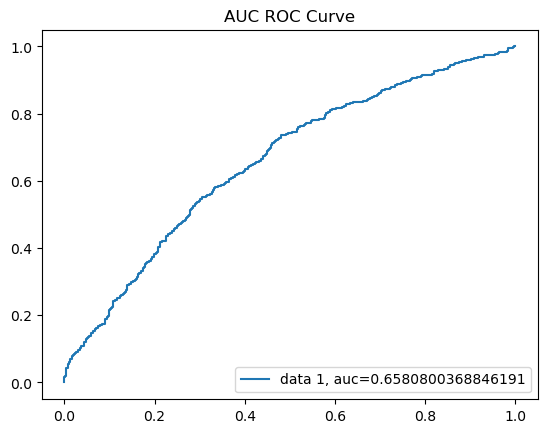

In [312]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [313]:
from sklearn.metrics import classification_report
auc = roc_auc_score(y_test, y_pred_proba) 
y_pred_binary = (y_pred_proba > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))
print('AUC-ROC score: ', auc)

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63       673
         1.0       0.61      0.60      0.61       651

    accuracy                           0.62      1324
   macro avg       0.62      0.62      0.62      1324
weighted avg       0.62      0.62      0.62      1324

AUC-ROC score:  0.6580800368846191


In [280]:
np.min(y_pred_proba)

0.006957125

In [23]:
model.save('model2.h5')
model.save_weights('my_model_weights.h5')  # to store


In [150]:
new_data  =data_scaled[105,:]
new_data = new_data[1:]
new_data

array([0.53846154, 0.5       , 0.20588235, 0.63333333, 0.2       ,
       0.02702703, 0.        , 0.08695652, 0.        , 0.        ,
       0.        , 0.        , 0.5       , 0.22091126, 0.50352113,
       0.147237  , 0.58873189, 0.20229226, 1.        , 0.06088825,
       0.34259259, 0.09319253, 0.78571429, 0.07811137, 0.9       ,
       0.20044282, 0.36144578, 0.12981697, 0.53333333, 0.07348727,
       0.68965517, 0.09013849, 0.38252811, 0.38888889, 0.16902459,
       0.48091603, 0.12443641, 0.4       , 0.09312321, 0.31034483,
       0.13488662, 1.        , 0.02826134, 0.66666667, 0.15311605,
       0.33783784, 0.11484677, 0.58823529, 0.0847063 , 0.41176471,
       0.0465616 , 0.46874317, 0.48507463, 0.08439799, 0.67340067,
       0.21178436, 1.        , 0.1535682 , 0.25531915, 0.03811522,
       0.9       , 0.1611877 , 0.        , 0.        , 0.        ,
       0.        , 0.70588235, 0.13900845, 0.31578947, 0.03410117,
       0.5189535 , 0.76785714, 0.21822619, 0.87      , 0.21670

In [151]:

new_data = np.reshape(new_data, (1,1,new_data.shape[0]))
new_data

array([[0.53846154, 0.5       , 0.20588235, 0.63333333, 0.2       ,
        0.02702703, 0.        , 0.08695652, 0.        , 0.        ,
        0.        , 0.        , 0.5       , 0.22091126, 0.50352113,
        0.147237  , 0.58873189, 0.20229226, 1.        , 0.06088825,
        0.34259259, 0.09319253, 0.78571429, 0.07811137, 0.9       ,
        0.20044282, 0.36144578, 0.12981697, 0.53333333, 0.07348727,
        0.68965517, 0.09013849, 0.38252811, 0.38888889, 0.16902459,
        0.48091603, 0.12443641, 0.4       , 0.09312321, 0.31034483,
        0.13488662, 1.        , 0.02826134, 0.66666667, 0.15311605,
        0.33783784, 0.11484677, 0.58823529, 0.0847063 , 0.41176471,
        0.0465616 , 0.46874317, 0.48507463, 0.08439799, 0.67340067,
        0.21178436, 1.        , 0.1535682 , 0.25531915, 0.03811522,
        0.9       , 0.1611877 , 0.        , 0.        , 0.        ,
        0.        , 0.70588235, 0.13900845, 0.31578947, 0.03410117,
        0.5189535 , 0.76785714, 0.21822619, 0.87

In [152]:
y_pred = model.predict(new_data)

1/1 [==============================] - 0s 23ms/step


In [27]:
y_pred

array([[0.04545613]], dtype=float32)

In [384]:
from datetime import date

today = date.today()
df_fighters_details['AGE'] = (pd.to_datetime(today) - pd.to_datetime(df_fighters_details['DOB'])).astype('<m8[Y]')

In [385]:
fighter2 = "Kamaru Usman"
fighter1= "Leon Edwards"


In [386]:
f1_df = df_fighters.loc[df_fighters['FIGHTER']==fighter1]
f2_df = df_fighters.loc[df_fighters['FIGHTER']==fighter2]

In [387]:
df_model.columns

Index(['Win', 'HEIGHT_diff', 'REACH_diff', 'AGE_diff', 'form_skore_fighter',
       'form_skore_opponent', 'fightNo_fighter', 'fightNo_opponent',
       'Win_tot_f1', 'DRAW_f1', 'No_contest_f1', 'Win_tot_f2', 'DRAW_f2',
       'No_contest_f2', 'CTRL_pct_fighterf1', 'SIG.STR._acc_fighterf1',
       'SIG.STR._perRound_fighterf1', 'TOTAL STR._acc_fighterf1',
       'TOTAL STR._perRound_fighterf1', 'TD_acc_fighterf1',
       'TD_perRound_fighterf1', 'HEAD_acc_fighterf1',
       'HEAD_perRound_fighterf1', 'BODY_acc_fighterf1',
       'BODY_perRound_fighterf1', 'LEG_acc_fighterf1',
       'LEG_perRound_fighterf1', 'DISTANCE_acc_fighterf1',
       'DISTANCE_perRound_fighterf1', 'CLINCH_acc_fighterf1',
       'CLINCH_perRound_fighterf1', 'GROUND_acc_fighterf1',
       'GROUND_perRound_fighterf1', 'CTRL_pct_opponentf1',
       'SIG.STR._acc_opponentf1', 'SIG.STR._perRound_opponentf1',
       'TOTAL STR._acc_opponentf1', 'TOTAL STR._perRound_opponentf1',
       'TD_acc_opponentf1', 'TD_perRound_

In [388]:
agediff = df_fighters_details[df_fighters_details['FIGHTER']==fighter1]['AGE'].values[0] - df_fighters_details[df_fighters_details['FIGHTER']==fighter2]['AGE'].values[0]
formy = [f1_df['form_skore_fighter'].values[0], f2_df['form_skore_fighter'].values[0]]
no_of_fights = [f1_df['Fights'].values[0],f2_df['Fights'].values[0]]
W_D_NC = f1_df[['Win','DRAW', 'No_contest']].values.tolist()[0] + f2_df[['Win','DRAW', 'No_contest']].values.tolist()[0]

In [389]:
sloupce2 = df_fighters.columns.tolist()[10:]
stats_f1 = []
stats_f2 = []
for sloupec in sloupce2:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        stats_f1.append((f1_df[sloupec]/f1_df['TotalTime']).values[0])
        stats_f2.append((f2_df[sloupec]/f2_df['TotalTime']).values[0])
    if 'attemps' in splited:
        stats_f1.append((f1_df[sloupec.replace('attemps', 'landed')]/f1_df[sloupec]).values[0])
        stats_f1.append((f1_df[sloupec.replace('attemps', 'landed')]/f1_df['TotalTime']).values[0]*300)
        
        stats_f2.append((f2_df[sloupec.replace('attemps', 'landed')]/f2_df[sloupec]).values[0])
        stats_f2.append((f2_df[sloupec.replace('attemps', 'landed')]/f2_df['TotalTime']).values[0]*300)
stats_list = stats_f1 + stats_f2

In [390]:
vstup = np.array([1]+[f1_df.iloc[0][col] - f2_df.iloc[0][col] for col in ['HEIGHT_fighter','REACH_fighter']] + [agediff] + formy + no_of_fights + W_D_NC + stats_list)

In [391]:
scaler = MinMaxScaler(feature_range=(0, 1))
vstup_scaled = scaler.fit_transform(df_model.append(pd.DataFrame(vstup.reshape(1,-1), columns=list(df_model)), ignore_index=True))[-1,:][1:]

C:\Users\spravce\AppData\Local\Temp\ipykernel_20476\2424742869.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vstup_scaled = scaler.fit_transform(df_model.append(pd.DataFrame(vstup.reshape(1,-1), columns=list(df_model)), ignore_index=True))[-1,:][1:]


In [392]:
vstup_scaled.shape[0]

89

In [393]:
new_data = np.reshape(vstup_scaled, (1,1,vstup_scaled.shape[0]))

In [394]:
new_data

array([[[0.57692308, 0.41666667, 0.38235294, 0.8       , 0.66666667,
         0.32432432, 0.35135135, 0.52173913, 0.        , 0.5       ,
         0.65217391, 0.        , 0.        , 0.25947704, 0.54791323,
         0.13418747, 0.59833834, 0.16340126, 0.33846154, 0.06561404,
         0.41738197, 0.09598415, 0.74301676, 0.09252174, 0.89320388,
         0.10036364, 0.4419778 , 0.18567562, 0.8125    , 0.0409453 ,
         0.76576577, 0.03752924, 0.26476602, 0.4684529 , 0.21368324,
         0.62798445, 0.21884675, 0.3164557 , 0.11403509, 0.37322275,
         0.15416515, 0.73958333, 0.131048  , 0.70247934, 0.10625   ,
         0.41044776, 0.17326468, 0.76724138, 0.07385439, 0.66019417,
         0.04431078, 0.49536984, 0.57510288, 0.23626661, 0.67513862,
         0.36565824, 0.48245614, 0.14220965, 0.43813273, 0.16664017,
         0.8043956 , 0.22073212, 0.87931034, 0.0964675 , 0.42089188,
         0.25321667, 0.81992337, 0.08347738, 0.76274945, 0.13167447,
         0.03235145, 0.42830995, 0

In [395]:
from keras.models import load_model
#model.load_weights('my_model_weights.h5')  # to load
y_pred = model.predict(new_data)
y_pred

1/1 [==============================] - 0s 18ms/step


array([[0.53495103]], dtype=float32)